<a href="https://colab.research.google.com/drive/1cuJsP-X7pOdvQGRxOBESp9N9HSiSUemQ?usp=sharing">
  <img align="center" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install transformers
!pip install sentencepiece
#!pip install tensorflow==2.4.0 

     |████████████████████████████████| 2.6 MB 33.0 MB/s 
     |████████████████████████████████| 895 kB 45.3 MB/s 
     |████████████████████████████████| 636 kB 51.0 MB/s 
     |████████████████████████████████| 3.3 MB 42.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


     |████████████████████████████████| 1.2 MB 30.6 MB/s 


In [ ]:
# import module
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
nltk.download("stopwords")
AUTO = tf.data.experimental.AUTOTUNE
MAX_LENGTHS = 50

NUM_CATEGORICAL = 4
dfResult = pd.DataFrame(columns=[ "rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","ModelName"])
HISTORY_TRANSFORMERS = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


IMPORTING ALL DATASETS

In [ ]:
!gdown --id 1dhdMKM9akp0krL9ObL-kn8K9gSVOwPUp
!gdown --id 1160UzrabHFjB4QjLs6IWU4mZ6fZroGNf
!gdown --id 10FbqBhDzGl_JsFLxFI8SvWmouc0FWQtd

Downloading...
From: https://drive.google.com/uc?id=1dhdMKM9akp0krL9ObL-kn8K9gSVOwPUp
To: /content/AllData.csv
3.25MB [00:00, 51.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1160UzrabHFjB4QjLs6IWU4mZ6fZroGNf
To: /content/All Data Undersampling Max 200.csv
100% 895k/895k [00:00<00:00, 14.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=10FbqBhDzGl_JsFLxFI8SvWmouc0FWQtd
To: /content/Normal.csv
100% 443k/443k [00:00<00:00, 7.01MB/s]


## Yow Read the Dataset

In [ ]:
!pip install openpyxl

In [ ]:
dfAllData = pd.read_csv("All Data Undersampling Max 200.csv")

In [ ]:
sample = dfAllData.loc[1,"tweet"]
def cleanIt(text):
  
  text = str(text)
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+" 

  text = re.sub(text_cleaning_hash, " ",text).rstrip()
  text = re.sub(text_cleaning_re, " ",text).rstrip()
  
  return text
cleanIt(sample)

'status dukung gerakan matikan lilin untuk ahok gubernur sebut akun facebok dihack'

In [ ]:
stopword = nltk.corpus.stopwords.words('indonesian')
def stopWord(text):
  text = text.split()
  return " ".join([t for t in text if t not in stopword])
stopWord("bilamana apabila saya  ")

'bilamana'

In [ ]:
dfNormal = pd.read_csv("Normal.csv")
dfAllData = dfAllData[dfAllData["labels"] != 0]


In [ ]:
#dfAllData.loc[dfAllData["labels"] == 3,"labels"]= 2

In [ ]:
dfNormal.loc[:,"labels"] = 0

In [ ]:
dfAllData = pd.concat([dfAllData,dfNormal])

In [ ]:
dfAllData["tweet"] = dfAllData["tweet"].apply(cleanIt)
dfAllData["tweet"] = dfAllData["tweet"].apply(stopWord)
dfAllData = dfAllData[dfAllData["tweet"].apply(lambda x : len(x.rstrip().split()) > 4) == True ]
dfAllData[dfAllData["tweet"].apply(lambda x : len(x.split()) < 4) == True]

,tweet,labels


In [ ]:
for i in range(5):
    dfAllData = dfAllData.sample(frac=1).reset_index(drop=True)

In [ ]:
import plotly.graph_objects as go
counted = dfAllData.groupby('labels')["labels"].aggregate("count")
print(counted)
fig = go.Figure()
fig.add_traces(go.Bar(y = ["Normal","Berita Bohong","HateSpeech","Offensive"],x = counted,orientation="h"))
fig.show()

labels
0    1759
1    1657
2    1572
3    1397
Name: labels, dtype: int64


## TransferLearning Section menggunakan transformer model

In [ ]:
# Check panjang text Narasi
from collections import Counter
seq_len = [len(text.split()) for text in dfAllData["tweet"] if type(text) != float]
print(Counter(seq_len))

Counter({6: 471, 7: 464, 5: 438, 9: 416, 8: 407, 12: 369, 10: 368, 11: 366, 13: 263, 14: 257, 15: 235, 18: 194, 16: 174, 17: 164, 19: 153, 20: 128, 23: 115, 21: 114, 22: 111, 24: 107, 27: 84, 26: 83, 25: 82, 29: 76, 28: 76, 31: 64, 30: 60, 32: 54, 35: 43, 34: 42, 33: 41, 36: 36, 37: 31, 39: 27, 41: 25, 40: 23, 38: 22, 42: 22, 43: 18, 44: 10, 45: 9, 48: 8, 46: 8, 47: 6, 84: 5, 57: 5, 54: 4, 59: 4, 52: 3, 110: 3, 74: 3, 55: 3, 98: 3, 75: 3, 61: 3, 58: 3, 108: 3, 88: 2, 93: 2, 79: 2, 82: 2, 116: 2, 53: 2, 135: 2, 49: 2, 68: 2, 120: 2, 121: 2, 70: 2, 62: 2, 131: 2, 89: 2, 114: 2, 69: 2, 96: 2, 115: 2, 67: 2, 76: 2, 119: 1, 92: 1, 64: 1, 111: 1, 85: 1, 102: 1, 173: 1, 73: 1, 66: 1, 60: 1, 87: 1, 141: 1, 164: 1, 51: 1, 107: 1, 171: 1, 148: 1, 118: 1, 123: 1, 124: 1, 169: 1, 97: 1, 159: 1, 56: 1, 112: 1, 50: 1, 81: 1, 104: 1, 122: 1, 133: 1, 77: 1, 128: 1, 127: 1, 113: 1})


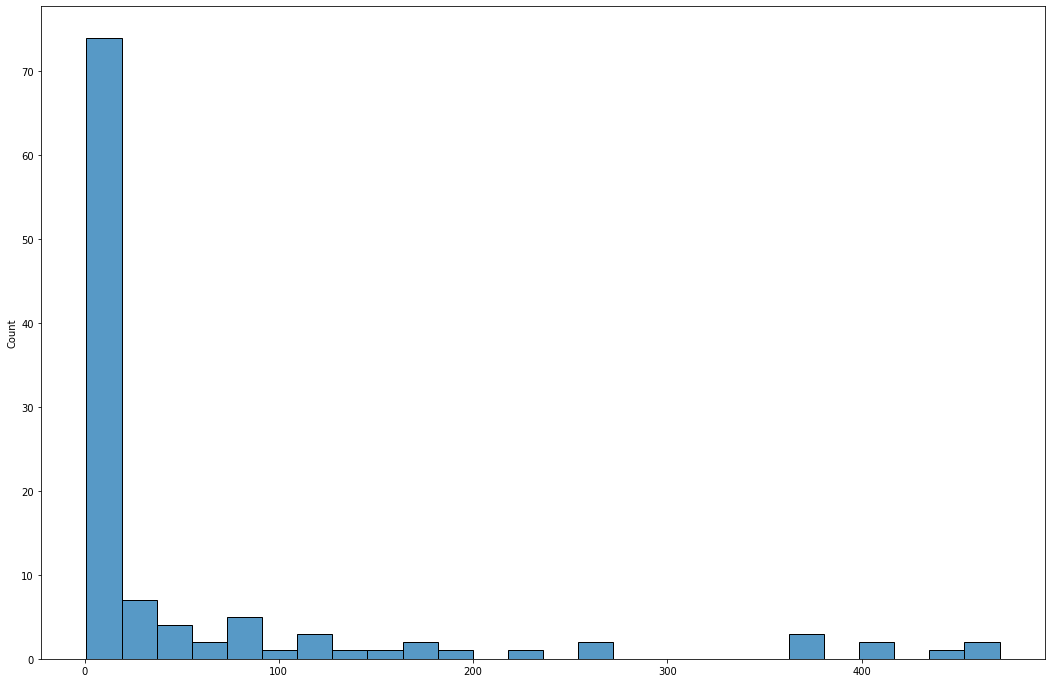

In [ ]:
plt.figure(figsize=(18,12))
sns.histplot(list(dict(Counter(seq_len)).values()))

In [ ]:
METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ]

In [ ]:
WORD_SIZE = 5000
def dataForLstm():
  from tensorflow.keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer(num_words = WORD_SIZE)
  tokenizer.fit_on_texts(dfAllData["tweet"].values)
  X = tokenizer.texts_to_sequences(dfAllData["tweet"].values)
  X = tf.keras.preprocessing.sequence.pad_sequences(X,maxlen=MAX_LENGTHS)
  Ylstm = tf.keras.utils.to_categorical(dfAllData["labels"])
  #x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = train_test_split(X,Ylstm,test_size=0.2,random_state=1)
  #return x_trainlstm,x_valLstm,y_trainlstm,y_valLstm
  return X,Ylstm
"""from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = WORD_SIZE)
tokenizer.fit_on_texts(dfAllData["tweet"].values)
X = tokenizer.texts_to_sequences(dfAllData["tweet"].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X)
Ylstm = tf.keras.utils.to_categorical(dfAllData["labels"])
#x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = train_test_split(X,Ylstm,test_size=0.001,random_state=1)
tokenizer.sequences_to_texts([x_trainlstm[0]])
#return x_trainlstm,x_valLstm,y_trainlstm,y_valLstm"""

'from tensorflow.keras.preprocessing.text import Tokenizer\ntokenizer = Tokenizer(num_words = WORD_SIZE)\ntokenizer.fit_on_texts(dfAllData["tweet"].values)\nX = tokenizer.texts_to_sequences(dfAllData["tweet"].values)\nX = tf.keras.preprocessing.sequence.pad_sequences(X)\nYlstm = tf.keras.utils.to_categorical(dfAllData["labels"])\n#x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = train_test_split(X,Ylstm,test_size=0.001,random_state=1)\ntokenizer.sequences_to_texts([x_trainlstm[0]])\n#return x_trainlstm,x_valLstm,y_trainlstm,y_valLstm'

In [ ]:
#Not Using its Attention to train.

NUM_CATEGORICAL = 4
def dataforIndoBert():
  tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

  token_train = {
      "tweet" : tokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  data = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["input_ids"])),
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return data["tweet"].numpy(),Y


def dataforRoberta():
  RobertaModelName = "cahya/roberta-base-indonesian-522M"
  RobertaTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_Roberta = {
      "tweet" : RobertaTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["input_ids"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataRoberta["tweet"].numpy(),Y


def dataforBert():
  BertModelName = "cahya/bert-base-indonesian-522M"
  BertModelTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_bert = {
      "tweet" : BertModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  train_databert = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_bert["tweet"]["input_ids"]))
  }


  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_databert["tweet"].numpy(),Y

def dataforGPT2():
  GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
  Gpt2ModelTokenizer = AutoTokenizer.from_pretrained(GPT2Modelname)
  Gpt2ModelTokenizer.pad_token = Gpt2ModelTokenizer.eos_token
  token_train_GPT2 = {
      "tweet" : Gpt2ModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          
          truncation = True
      ),
  }

  train_dataGPT2 = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["input_ids"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataGPT2["tweet"].numpy(),Y
def dataforXLMRoBERTa():

  XLMRobertaName = "jplu/tf-xlm-roberta-base"
  XLMRobertaMultiLingualTokenizer = AutoTokenizer.from_pretrained(XLMRobertaName)

  token_train_XLMRoberta = {
      "tweet" : XLMRobertaMultiLingualTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataXLMRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["input_ids"]))
  }

  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataXLMRoberta["tweet"].numpy(), Y

In [ ]:
#Not Using its Attention to train.

NUM_CATEGORICAL = 4
def dataforIndoBertAttention():
  tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

  token_train = {
      "tweet" : tokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  data = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["input_ids"])),
    "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["attention_mask"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  data = {
      "tweet" : data["tweet"].numpy(),
      "tweetMask" : data["tweet"].numpy()
  }
  return data,Y


def dataforRobertaAttention():
  RobertaModelName = "cahya/roberta-base-indonesian-522M"
  RobertaTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_Roberta = {
      "tweet" : RobertaTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["input_ids"])),
       "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["attention_mask"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  train_dataRoberta = {
      "tweet" : train_dataRoberta["tweet"].numpy(),
      "tweetMask" : train_dataRoberta["tweet"].numpy()
  }
  return train_dataRoberta,Y


def dataforBertAttentions():
  BertModelName = "cahya/bert-base-indonesian-522M"
  BertModelTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_bert = {
      "tweet" : BertModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  train_databert = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_bert["tweet"]["input_ids"])),
      "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train_bert["tweet"]["attention_mask"]))
  }


  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  train_databert = {
      "tweet" : train_databert["tweet"].numpy(),
      "tweetMask" : train_databert["tweet"].numpy()
  }
  return train_databert,Y

def dataforGPT2Attentions():
  GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
  Gpt2ModelTokenizer = AutoTokenizer.from_pretrained(GPT2Modelname)
  Gpt2ModelTokenizer.pad_token = Gpt2ModelTokenizer.eos_token
  token_train_GPT2 = {
      "tweet" : Gpt2ModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          
          truncation = True
      ),
  }

  train_dataGPT2 = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["input_ids"])),
      "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["attention_mask"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  train_dataGPT2 = {
      "tweet" : train_dataGPT2["tweet"].numpy(),
      "tweetMask" : train_dataGPT2["tweet"].numpy()
  }
  return train_dataGPT2,Y
def dataforXLMRoBERTaAttention():

  XLMRobertaName = "jplu/tf-xlm-roberta-base"
  XLMRobertaMultiLingualTokenizer = AutoTokenizer.from_pretrained(XLMRobertaName)

  token_train_XLMRoberta = {
      "tweet" : XLMRobertaMultiLingualTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataXLMRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["input_ids"])),
      "tweetMask" :  tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["attention_mask"]))
  }

  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)
  train_dataXLMRoberta = {
      "tweet" : train_dataXLMRoberta["tweet"].numpy(),
      "tweetMask" : train_dataXLMRoberta["tweet"].numpy()
  }
  return train_dataXLMRoberta, Y

In [ ]:
## Architecture
def architectureTransformers(passedModel):
  METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ]

  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweet")
  #attentions = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweetMask")
  last_hidden_state, pooler_output = passedModel(ids1).to_tuple()
  layers = tf.keras.layers.Flatten()(last_hidden_state)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  layers = tf.keras.layers.Dense(1024,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  fin_layer = tf.keras.layers.Dense(NUM_CATEGORICAL,activation= tf.nn.softmax)(layers)

  final = tf.keras.Model(inputs=[ids1],outputs=[fin_layer])
  
  for layer in final.layers:
    layer.trainable = False
  
  for layer in final.layers[2:]:
    layer.trainable = True 
  optimizer = tf.keras.optimizers.Adam(learning_rate=.0001)
  final.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer,metrics = METRICS)

  return final

In [ ]:
METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),]

In [ ]:
def indoBertModelAttention():
  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweet")
  attention = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweetMask")

  last_hidden_state, pooler_output = IndoBert(ids1,attention_mask=attention).to_tuple()
  layers = tf.keras.layers.Flatten()(last_hidden_state)
  layers = tf.keras.layers.Dense(units=500,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dropout(0.4)(layers)
  fin_layer = tf.keras.layers.Dense(NUM_CATEGORICAL,activation= tf.nn.softmax)(layers)

  final = tf.keras.Model(inputs=[ids1,attention],outputs=[fin_layer])
  
  for layer in final.layers:
    layer.trainable = False
  for layer in final.layers[2:]:
    layer.trainable = True 
  optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
  final.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer,metrics = METRICS)

  return final

In [ ]:
## LSTM MODELS basic Attentions
RNN_CELL_SIZE = 32
class Attention(tf.keras.Model):
  def __init__(self,units):
    super(Attention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self,features,hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(
        self.W1(features) + self.W2(hidden_with_time_axis)
    )
    attention_weights = tf.nn.softmax(self.V(score), axis = 1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis= 1)
    return context_vector, attention_weights
def attentionLayer():
  sequence_input = tf.keras.Input(shape=(MAX_LENGTHS,),dtype=tf.int32)
  embedded_sequences = tf.keras.layers.Embedding(WORD_SIZE, MAX_LENGTHS)(sequence_input)
  lstmLayer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(RNN_CELL_SIZE, return_sequences=True),name= "bi_lstm")(embedded_sequences)
  (lstm,forward_h, forward_c, backward_h, backward_c) = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(RNN_CELL_SIZE,return_state=True), name="bi_lstm_1")(lstmLayer)
  state_h = tf.keras.layers.Concatenate()([forward_h,backward_h])
  state_c = tf.keras.layers.Concatenate()([forward_c,backward_c])
  context_vector ,attention_weights = Attention(10)(lstm,state_h)
  dense = tf.keras.layers.Dense(20 ,activation = tf.nn.relu)(context_vector)
  dense = tf.keras.layers.Dropout(0.10)(dense)
  output = tf.keras.layers.Dense(4, activation = tf.nn.softmax)(dense)

  model = tf.keras.Model(inputs = [sequence_input], outputs = output)
  print(model.summary())
  tf.keras.utils.plot_model(model, show_shapes=True, dpi=90)
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=METRICS)
  return model
#x_dataLstm,x_valLstm,y_dataLstm,y_valLstm = dataForLstm()
#model = attentionLayer()
#EPOCHS = 5
#history = model.fit(x_dataLstm,y_dataLstm,
#                    batch_size=64,
#                    epochs=EPOCHS,
#                    validation_split=0.2)

def lstmModel(X):
  input_lstm = tf.keras.layers.Input(shape=(X,),dtype = tf.int32,name="tweet")
  layers  = tf.keras.layers.Embedding(WORD_SIZE,23 )(input_lstm)
  layers = tf.keras.layers.SpatialDropout1D(0.4)(layers)
  layers = tf.keras.layers.LSTM(64, activation=tf.nn.tanh,dropout = 0.4,recurrent_dropout=0.2,)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  output = tf.keras.layers.Dense(4,activation=tf.nn.softmax)(layers)
  
  model = tf.keras.Model(inputs= [input_lstm], outputs = [output])

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer= tf.keras.optimizers.Adam(0.001),
                metrics = METRICS)
  return model

def lstmBidirectional(X):
  input_lstm = tf.keras.layers.Input(shape=(X,),dtype = tf.int32,name="tweet")
  layers  = tf.keras.layers.Embedding(WORD_SIZE,23 )(input_lstm)
  layers = tf.keras.layers.SpatialDropout1D(0.4)(layers)
  layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation=tf.nn.tanh,dropout = 0.4,recurrent_dropout=0.2))(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  output = tf.keras.layers.Dense(4,activation=tf.nn.softmax)(layers)
  
  model = tf.keras.Model(inputs= [input_lstm], outputs = [output])

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer= tf.keras.optimizers.Adam(0.001),
                metrics = METRICS)
  return model
#x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = dataForLstm()
#model = lstmModel(142)
#EPOCHS = 10
#history = model.fit(x=x_trainlstm,y=y_trainlstm ,validation_data = (x_valLstm,y_valLstm),batch_size=64,epochs=EPOCHS)

In [ ]:
"""pred = model.predict(X)
def getDifferTrainingLSTM(dat,y_train,pred):
  y_train = np.argmax(y_train,axis=1)
  pred = np.argmax(pred,axis=1)
  print(pred)
  differ = []
  for indx,content in enumerate(dat[:,0]):
     if (y_train[indx] != pred[indx]):
       differ.append( (indx,tokenizer.sequences_to_texts(dat[[indx]]),y_train[indx],pred[indx] ))
  return differ
pd.DataFrame(getDifferTrainingLSTM(X,Ylstm,pred)).to_excel("Klasifikasi yang SalahLSTM.xlsx",index=False)
"""

'pred = model.predict(X)\ndef getDifferTrainingLSTM(dat,y_train,pred):\n  y_train = np.argmax(y_train,axis=1)\n  pred = np.argmax(pred,axis=1)\n  print(pred)\n  differ = []\n  for indx,content in enumerate(dat[:,0]):\n     if (y_train[indx] != pred[indx]):\n       differ.append( (indx,tokenizer.sequences_to_texts(dat[[indx]]),y_train[indx],pred[indx] ))\n  return differ\npd.DataFrame(getDifferTrainingLSTM(X,Ylstm,pred)).to_excel("Klasifikasi yang SalahLSTM.xlsx",index=False)\n'

In [ ]:
"""def changeTheLabels(df1,df2):
  for i in (df2.loc[:,3]):
    print(i)
    if (df1.loc[i,"labels"] != df2.loc[i,3]):
      df1.loc[i,"labels"] = df2.loc[i,3]
  print("changed Succesfully blok")
copyDfAllData = dfAllData.copy()
changeTheLabels(copyDfAllData,checkitBrot)"""

'def changeTheLabels(df1,df2):\n  for i in (df2.loc[:,3]):\n    print(i)\n    if (df1.loc[i,"labels"] != df2.loc[i,3]):\n      df1.loc[i,"labels"] = df2.loc[i,3]\n  print("changed Succesfully blok")\ncopyDfAllData = dfAllData.copy()\nchangeTheLabels(copyDfAllData,checkitBrot)'

In [ ]:
"""copyDfAllData.to_csv("DataSwapped.csv",index=False)"""

'copyDfAllData.to_csv("DataSwapped.csv",index=False)'

In [ ]:
"""checkitBrot = pd.read_excel("Klasifikasi yang SalahLSTM.xlsx")
checkitBrot"""

'checkitBrot = pd.read_excel("Klasifikasi yang SalahLSTM.xlsx")\ncheckitBrot'

In [ ]:
def initLstm(X):
    return [lstmModel(X),lstmBidirectional(X)]

In [ ]:
FinalHistory_lstm = []
trainedLstmModels = []
splits = 5
EPOCHS = 8

def TrainLSTModels(splits,EPOCHS):
    from sklearn.model_selection import StratifiedShuffleSplit
    skf = StratifiedShuffleSplit(n_splits=splits,random_state=10)
    modelNames = ["LSTM","LSTM Bidirectional"]
    lstm,lstmBd = initLstm(MAX_LENGTHS)
    lstmModels = [lstm,lstmBd]
    Xdat,Ydat = dataForLstm()
    fold = 1
    for modelname, model in zip(modelNames,lstmModels):
        HISTORY_LSTM = []
        for train_indx, val_indx in skf.split(Xdat,np.argmax(Ydat,axis=1)):
            print("============================================")
            print(f"TRAINING {modelname} : , {fold}" )
            if(modelname == "LSTM"):
              model = lstmModel(MAX_LENGTHS)
            elif(modelname == "LSTM Bidirectional"):
              model = lstmBidirectional(MAX_LENGTHS)
            tf.keras.backend.clear_session()
            train = Xdat[train_indx]
            val = Xdat[val_indx]
            ytrain = Ydat[train_indx] 
            yval = Ydat[val_indx]
            trainData = (tf.data.Dataset.from_tensor_slices((train,ytrain))).batch(64).prefetch(AUTO)
            valData = (tf.data.Dataset.from_tensor_slices((val,yval))).batch(64).prefetch(AUTO).cache()
            history = model.fit( (trainData),validation_data = valData,epochs=EPOCHS)
            #print(f"Scores For fold {fold} ACC {history.history['accuracy'].mean()} , VAL ACC {history.history['val_accuracy'].mean()}")
            data = ("rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","f1ScoreTrain","f1ScoreVal")
            datBang = [ (np.mean(history.history["accuracy"]), np.mean(history.history["val_accuracy"]),
                         np.mean(history.history["loss"]), np.mean(history.history["val_loss"]),
                         np.mean(history.history["precision"]), np.mean(history.history["val_precision"]),
                         np.mean(history.history["recall"]), np.mean(history.history["val_recall"]) )  ]
            HISTORY_LSTM.append(datBang)
            fold += 1
        hist = np.array(HISTORY_LSTM,dtype=np.float32).reshape(splits,8)
        data = (hist[:,0].mean(),hist[:,1].mean(),hist[:,2].mean(),
                hist[:,3].mean(),hist[:,4].mean(),hist[:,5].mean(),
                hist[:,6].mean(),hist[:,7].mean(),modelname)
        FinalHistory_lstm.append((data))
        trainedLstmModels.append(model)
TrainLSTModels(splits,EPOCHS)

TRAINING LSTM : , 1
Epoch 1/8
90/90 [==============================] - 25s 212ms/step - loss: 1.1039 - tp: 920.0000 - fp: 109.0000 - tn: 17129.0000 - fn: 4826.0000 - accuracy: 0.4551 - precision: 0.8941 - recall: 0.1601 - auc: 0.7520 - val_loss: 0.8509 - val_tp: 165.0000 - val_fp: 3.0000 - val_tn: 1914.0000 - val_fn: 474.0000 - val_accuracy: 0.5728 - val_precision: 0.9821 - val_recall: 0.2582 - val_auc: 0.8622
Epoch 2/8
90/90 [==============================] - 18s 197ms/step - loss: 0.7319 - tp: 2361.0000 - fp: 397.0000 - tn: 16841.0000 - fn: 3385.0000 - accuracy: 0.6556 - precision: 0.8561 - recall: 0.4109 - auc: 0.9009 - val_loss: 0.6044 - val_tp: 348.0000 - val_fp: 63.0000 - val_tn: 1854.0000 - val_fn: 291.0000 - val_accuracy: 0.7340 - val_precision: 0.8467 - val_recall: 0.5446 - val_auc: 0.9367
Epoch 3/8
90/90 [==============================] - 19s 208ms/step - loss: 0.5504 - tp: 3896.0000 - fp: 911.0000 - tn: 16327.0000 - fn: 1850.0000 - accuracy: 0.7567 - precision: 0.8105 - reca

In [ ]:
dfResultLstm = pd.DataFrame(FinalHistory_lstm,columns=[ "rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","ModelName"])
dfResultLstm.to_excel("ResultLstm.xlsx",index=False)

In [ ]:
# Using its Attention to train.

def dataforIndoBert():
  tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

  token_train = {
      "tweet" : tokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  data = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["input_ids"])),
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return data["tweet"].numpy(),Y


def dataforRoberta():
  RobertaModelName = "cahya/roberta-base-indonesian-522M"
  RobertaTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_Roberta = {
      "tweet" : RobertaTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["input_ids"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataRoberta["tweet"].numpy(),Y


def dataforBert():
  BertModelName = "cahya/bert-base-indonesian-522M"
  BertModelTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
  token_train_bert = {
      "tweet" : BertModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }
  train_databert = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_bert["tweet"]["input_ids"]))
  }


  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_databert["tweet"].numpy(),Y

def dataforGPT2():
  GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
  Gpt2ModelTokenizer = AutoTokenizer.from_pretrained(GPT2Modelname)
  Gpt2ModelTokenizer.pad_token = Gpt2ModelTokenizer.eos_token
  token_train_GPT2 = {
      "tweet" : Gpt2ModelTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          
          truncation = True
      ),
  }

  train_dataGPT2 = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["input_ids"]))
  }
  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataGPT2["tweet"].numpy(),Y
def dataforXLMRoBERTa():

  XLMRobertaName = "jplu/tf-xlm-roberta-base"
  XLMRobertaMultiLingualTokenizer = AutoTokenizer.from_pretrained(XLMRobertaName)

  token_train_XLMRoberta = {
      "tweet" : XLMRobertaMultiLingualTokenizer.batch_encode_plus(
          dfAllData["tweet"].to_list(),
          max_length = MAX_LENGTHS,
          pad_to_max_length = True,
          truncation = True
      ),
  }

  train_dataXLMRoberta = {
      "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["input_ids"]))
  }

  Y = tf.convert_to_tensor(dfAllData["labels"])
  Y = to_categorical(Y,NUM_CATEGORICAL)

  return train_dataXLMRoberta["tweet"].numpy(), Y

In [ ]:

IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

RobertaModelName = "cahya/roberta-base-indonesian-522M"
RobertaModel = TFAutoModel.from_pretrained(RobertaModelName)

BertModelName = "cahya/bert-base-indonesian-522M"
BertModel = TFAutoModel.from_pretrained(BertModelName)

XLMRobertaName = "jplu/tf-xlm-roberta-base"
XLMRobertaMultiLingualModel = TFAutoModel.from_pretrained(XLMRobertaName)

GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
Gpt2Model = TFAutoModel.from_pretrained(GPT2Modelname)

def indoBertModel():
  return architectureTransformers(IndoBert)

def robertaModel():
  model = architectureTransformers(RobertaModel)
  return model

def bertModel():
  model = architectureTransformers(BertModel)
  return model

def GPT2Model():
  return architectureTransformers(Gpt2Model)

def XlmRoberta():
  return architectureTransformers(XLMRobertaMultiLingualModel)

def initModel():
  return bertModel(),indoBertModel(),robertaModel(),XlmRoberta(),GPT2Model()

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at cahya/roberta-base-indonesian-522M were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cahya/roberta-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at cahya/gpt2-small-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
historyCopy = FinalHistory_Transformers.copy()

In [ ]:
dfResultTransformer

,rataAccTrain,rataAccVal,rataLossTrain,rataLossVal,precisionTrain,precisionVal,recallTrain,recallVal,ModelName
0,0.760934,0.729679,0.836613,0.690957,0.813172,0.771595,0.705902,0.690525,IndoBert
1,0.733144,0.683066,0.914932,0.824067,0.783651,0.727146,0.674966,0.634926,Roberta
2,0.580942,0.549471,1.273677,1.075528,0.755477,0.718727,0.425078,0.396829,Bert
3,0.678186,0.650548,1.716543,1.161275,0.798302,0.782440,0.579141,0.547670,GPT2


In [ ]:
dfResultTransformer =  pd.DataFrame(FinalHistory_Transformers,columns=[ "rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","ModelName"])

#dfResultTransformer.to_excel("ResultTransformerMerged.xlsx",index=False)

In [ ]:
FinalHistory_Transformers = []
trainedTransformerModels = []
splits = 5
EPOCHS = 8
def TrainAttentions(splits,EPOCHS):
  from sklearn.model_selection import StratifiedShuffleSplit
  skf = StratifiedShuffleSplit(n_splits=splits)

  fold = 1
  #y_train= np.argmax(y_train,axis=1)
  historyList = [] 
  bertmodelObj,indobertModelObj,robertaModelObj,xlmRobertaModelObj,GPT2ModelObj = initModel()
  modelNames = ["IndoBert","Roberta","Bert","GPT2","XLMROBERTA"]
  modelTransformers = [indobertModelObj,robertaModelObj,bertmodelObj,GPT2Model,xlmRobertaModelObj]
  dataTransformers = [dataforIndoBert(),dataforRoberta(),dataforBert(),dataforGPT2(),dataforXLMRoBERTa()]
  for modelname, model,content in zip(modelNames,modelTransformers,dataTransformers):
    HISTORY_TRANSFORMERS = []
    for train_indx, val_indx in skf.split(content[0],np.argmax(content[1],axis=1)):
      print("============================================")
      print(f"TRAINING {modelname} : , {fold}" )
      if (modelname == "IndoBert"):
        model = indoBertModel()
      elif (modelname=="Roberta"):
        model = robertaModel()
      elif (modelname == "Bert"):
        model = bertModel()
      elif (modelname == "GPT2"):
        model = GPT2Model()
      elif (modelname == "XLMROBERTA"):
        mdeol = XlmRoberta()
      train = content[0][train_indx]
      val = content[0][val_indx]
      ytrain = content[1][train_indx] 
      yval = content[1][val_indx]
      trainData = (tf.data.Dataset.from_tensor_slices((train,ytrain))).batch(64).prefetch(AUTO)
      valData = (tf.data.Dataset.from_tensor_slices((val,yval))).batch(64).prefetch(AUTO).cache()
      history = model.fit( (trainData),validation_data = valData,epochs=EPOCHS)
      data = ("rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","f1ScoreTrain","f1ScoreVal")
      datBang = [ (np.mean(history.history["accuracy"]), np.mean(history.history["val_accuracy"]),
                         np.mean(history.history["loss"]), np.mean(history.history["val_loss"]),
                         np.mean(history.history["precision"]), np.mean(history.history["val_precision"]),
                         np.mean(history.history["recall"]), np.mean(history.history["val_recall"]) )  ]
      HISTORY_TRANSFORMERS.append(datBang)
      fold += 1
    hist = np.array(HISTORY_TRANSFORMERS,dtype=np.float32).reshape(splits,EPOCHS)
    data = (hist[:,0].mean(),hist[:,1].mean(),hist[:,2].mean(),
                hist[:,3].mean(),hist[:,4].mean(),hist[:,5].mean(),
                hist[:,6].mean(),hist[:,7].mean(),modelname)
    FinalHistory_Transformers.append((data))
    trainedTransformerModels.append(model)
TrainAttentions(splits,EPOCHS)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



TRAINING IndoBert : , 1
Epoch 1/8
90/90 [==============================] - 37s 275ms/step - loss: 1.2016 - tp: 2446.0000 - fp: 1252.0000 - tn: 15986.0000 - fn: 3300.0000 - accuracy: 0.5639 - precision: 0.6614 - recall: 0.4257 - auc: 0.8092 - val_loss: 0.6689 - val_tp: 399.0000 - val_fp: 85.0000 - val_tn: 1832.0000 - val_fn: 240.0000 - val_accuracy: 0.7136 - val_precision: 0.8244 - val_recall: 0.6244 - val_auc: 0.9208
Epoch 2/8
90/90 [==============================] - 22s 243ms/step - loss: 0.6928 - tp: 3346.0000 - fp: 914.0000 - tn: 16324.0000 - fn: 2400.0000 - accuracy: 0.6993 - precision: 0.7854 - recall: 0.5823 - auc: 0.9148 - val_loss: 0.6415 - val_tp: 427.0000 - val_fp: 113.0000 - val_tn: 1804.0000 - val_fn: 212.0000 - val_accuracy: 0.7324 - val_precision: 0.7907 - val_recall: 0.6682 - val_auc: 0.9292
Epoch 3/8
90/90 [==============================] - 22s 247ms/step - loss: 0.6140 - tp: 3686.0000 - fp: 874.0000 - tn: 16364.0000 - fn: 2060.0000 - accuracy: 0.7302 - precision: 0.808

In [ ]:
dfResultTransformer =  pd.DataFrame(FinalHistory_Transformers,columns=[ "rataAccTrain", "rataAccVal",
                    "rataLossTrain", "rataLossVal",
                    "precisionTrain","precisionVal",
                    "recallTrain","recallVal","ModelName"])
dfResultTransformer
dfResultTransformer.to_excel("ResultTransformer.xlsx",index=False)

In [ ]:
dfResultTransformer

,rataAccTrain,rataAccVal,rataLossTrain,rataLossVal,precisionTrain,precisionVal,recallTrain,recallVal,ModelName
0,0.715306,0.731768,0.661353,0.618743,0.805034,0.807167,0.609998,0.643975,IndoBert
1,0.686773,0.690376,0.714811,0.710803,0.792033,0.802806,0.565163,0.559155,Roberta
2,0.551440,0.560446,0.971294,0.962248,0.773069,0.789500,0.337865,0.330282,Bert
3,0.688214,0.708255,0.749978,0.686671,0.789768,0.803694,0.577245,0.585094,GPT2
4,0.651127,0.686737,0.758883,0.700239,0.806019,0.864705,0.491955,0.498826,XLMROBERTA


In [ ]:
for i in dfAllData[dfAllData["labels"] == 2]["tweet"]:
  print(i)

berharap pks bubar partai komunis indonesia pdip bubar
suciwati revolusi mental jokowi omong kosongbualan setuju amp komen
secuil ketulusan amp keikhlasan sandiaga uno hx wakil gubernur mbuat sia pencitran sang ambisius
politisi bangsat berlomba siasat sesat pikiran rakyatntidak ber posisi oposisi samasama bejatnyang fanatik giat rakyat penatnpolitisi jerawat pantat bodat
kejamnya jejak digital politikus narkotika psikotropika obat terlarang
partai dibangkitkan faham komunis bangkitkan ditanamkan rezim
mari rapatkan barisan target nya lengserkan jokowi isu partai komunis indonesia pembela kafir pri non pri
calon presidenya jokowi dipasangan surabaya pilih jokowi tamat puncaknya
ahok cari cari celah serang saksi dramahokdikriminalisasi penjarakan ahok
kabinet berantakan npemecah belah persatuan rezim
menteri perdagangan cinasdh numpang cari makan hidup indonesia cari perkara pribumi usir nkri
kerja diktator jokowi gunting pita bagibagi sertifikat macamacam upacara memenuhi janjinya
trio

In [ ]:
X,Y = dataForLstm()
model = lstmModel(50)
EPOCHS = 8
history = model.fit(x=X,y=Y ,validation_split = 0.20,batch_size=64,epochs=EPOCHS)

Epoch 1/8
80/80 [==============================] - 27s 256ms/step - loss: 1.1669 - tp: 628.0000 - fp: 75.0000 - tn: 15249.0000 - fn: 4480.0000 - accuracy: 0.4499 - precision: 0.8933 - recall: 0.1229 - auc: 0.7241 - val_loss: 0.8637 - val_tp: 366.0000 - val_fp: 19.0000 - val_tn: 3812.0000 - val_fn: 911.0000 - val_accuracy: 0.5826 - val_precision: 0.9506 - val_recall: 0.2866 - val_auc: 0.8551
Epoch 2/8
80/80 [==============================] - 20s 246ms/step - loss: 0.7849 - tp: 2014.0000 - fp: 372.0000 - tn: 14952.0000 - fn: 3094.0000 - accuracy: 0.6243 - precision: 0.8441 - recall: 0.3943 - auc: 0.8850 - val_loss: 0.6798 - val_tp: 738.0000 - val_fp: 229.0000 - val_tn: 3602.0000 - val_fn: 539.0000 - val_accuracy: 0.6750 - val_precision: 0.7632 - val_recall: 0.5779 - val_auc: 0.9148
Epoch 3/8
80/80 [==============================] - 20s 246ms/step - loss: 0.6089 - tp: 2959.0000 - fp: 693.0000 - tn: 14631.0000 - fn: 2149.0000 - accuracy: 0.7179 - precision: 0.8102 - recall: 0.5793 - auc: 0

In [ ]:
!gdown --id 1qsgKjgJhG1NO0kmUbg5LvGf0SNXckPoU
WORD_SIZE = 5000
def dataForLstmtest():
  from tensorflow.keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer(num_words = WORD_SIZE)
  tokenizer.fit_on_texts(dfAllData["tweet"].values)
  X = tokenizer.texts_to_sequences(dfAllData["tweet"].values)
  X = tf.keras.preprocessing.sequence.pad_sequences(X,maxlen=MAX_LENGTHS)
  Ylstm = tf.keras.utils.to_categorical(dfAllData["labels"])
  return tokenizer
tokenizerTest = dataForLstmtest()
test = pd.read_excel("datatest.xlsx")
test["text"] = test["text"].apply(cleanIt)
test["text"] = test["text"].apply(stopWord)
test= tokenizerTest.texts_to_sequences(test["text"])
test = tf.keras.preprocessing.sequence.pad_sequences(test,maxlen=MAX_LENGTHS)
pred = np.argmax(model.predict(test),axis=1)

pred

Downloading...
From: https://drive.google.com/uc?id=1qsgKjgJhG1NO0kmUbg5LvGf0SNXckPoU
To: /content/datatest.xlsx
100% 9.50k/9.50k [00:00<00:00, 15.5MB/s]


array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 3, 3, 1, 3, 3])